# Setup

In [3]:
# %load_ext autoreload ##### autoreload conflicts with workflow
# %autoreload 2
import warnings
warnings.filterwarnings('once')
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
import numpy as np
import pandas as pd
from scipy.stats import zscore, pearsonr, spearmanr
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import hdf5storage
from tqdm.notebook import tqdm
from neurodsp.spectral import compute_spectrum
from timescales.autoreg import compute_ar_spectrum
from timescales.fit import PSD, ACF
from ndspflow.workflows import WorkFlow
import timescale_development_hf as hf

AttributeError: module 'pandas' has no attribute '__version__'

In [ ]:
def h_line(x_data, b):
    y = [b]*len(x_data)
    return y


def sf(x,amplitude,offset,gain,midpoint):
    return amplitude / (1 + np.exp((-gain * x) - midpoint)) + offset


def gaus(x,a,x0,sigma,c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + c


def fig2_timescales(time, timescales, fit_method = None, sig_func_type=sf, guess_h1=None, guess_h2=None, top_axis=False):
    sorted_index = np.argsort(time)
    time = time[np.argsort(time)]
    timescales = timescales[sorted_index]
    
    # plot data points
    plt.figure(figsize=(6,5))
    plt.plot(time, timescales,'.',color="dimgrey")
    plt.xticks(size=13)
    plt.yticks(size=13)
    
    # fit straight line model - yellow
    guess_h0 = np.mean(timescales)
    params_h0,_ = curve_fit(h_line,time,timescales,method=fit_method,p0=guess_h0)
    y_h0 = h_line(time, params_h0)
    plt.plot(time,y_h0,'-.',color='#FDAE61',linewidth=5,dashes=(5,2))
    
    # fit sigmoid model - blue
    params_h1,_ = curve_fit(sig_func_type,time,timescales,method=fit_method,p0=guess_h1,maxfev = 10000)
    y_h1 = sig_func_type(time, *params_h1)
    plt.plot(time,y_h1,'-.',color='#2D7BB6',linewidth=5,dashes=(4,2))
    
    # fit inverted u gaussian model - red
    params_h2,_ = curve_fit(gaus,time,timescales,method=fit_method,p0=guess_h2,bounds=((0,min(time),-np.inf,-np.inf),(1,max(time),np.inf,np.inf)))
    y_h2 = gaus(time,*params_h2)
    plt.plot(time,y_h2,'-.',color='#D7191D',linewidth=5,dashes=(2,2))
    
    
    months = ['3.3', '4.1', '4.9', '5.8','6.6','7.4','8.2','9.0']
    
    locs, labels = plt.xticks()
    print(locs)
    labels = months
    plt.xticks(locs[1:-1], labels) 
    
    return [params_h0, params_h1, params_h2]

In [ ]:
# data directory
data_dir = '/Users/trevormcpherson/Desktop/PhD/Voytek/Organoids/organoidData/CTC/'
#'/Users/blancamartin/Desktop/Voytek_Lab/timescales/organoid_data/CTC_data/'

# file type, constant, for each recording there is a directory that is the name of the recording, and then this file name within it
file_type = 'LFP_Sp.mat'

# all recording folders have this string in their name
recording_string = 'CTC'

# string to screen out drug manipulation recordings
drug_recording_string = 'Drugs'

# get recording directories
recording_directories = os.listdir(data_dir)

# only keep recording directories
recording_directories = [s for s in recording_directories if (recording_string in s) & (drug_recording_string not in s)]

# number of recordings
n_recordings = len(recording_directories)

# total number of wells
total_n_wells = 12

# no data in first 4 wells, if not specifying specific ones to analyze, skip these first 4
wells_to_skip = 4

# number of wells
n_wells = total_n_wells - wells_to_skip

# number of channels
n_channels = 64

# spike recording sample rate
spike_sample_rate = 12500 # samp per sec

# length of time bins using to separate spikes (seconds)
bin_length = 0.05

# binned data sample rate
bin_sample_rate = 1 / bin_length

# bin length in ms
bin_length_ms = int(bin_length * 1000)

# param for determining network spiking events, floor division of the maximum spikes found in a bin by this number
max_spike_floor_division = 2

# analysis window kernel (seconds, total of 3)
kernel_window_sec = [-0.5,2.5]

# length of kernel window
kernel_window_length = np.abs(kernel_window_sec[0]) + kernel_window_sec[1]

# convert to bins
kernel_window_idx = np.divide(kernel_window_sec,bin_length).astype(int)

num_bins_kernel = np.abs(kernel_window_idx[0]) + kernel_window_idx[1]
# get sequential times of bins in kernel

kernel_times = np.linspace(0,kernel_window_length,num_bins_kernel)

# day for organoid differentation as a time object
day_diff = datetime.strptime("081116",'%m%d%y')

# AR spectrum calculation order
ar_spec_order = [3] # [1,2,3,4,5]

# spike threshold (in step 3)
skp_thresh = 0 # remove electrodes with less than 200 spikes

# Analysis date
date_str = datetime.now().strftime('%Y-%m-%d_%H%M')
print(date_str)

In [ ]:
# Update this with anaysis date printed from previous cell to save out a new version of the results
# or load a previously run version later in the script if visualizing
date_str = '2023-08-14_1423'# 2023-07-26_1521_double 2023-04-14_1050 2023-02-23_1019 2023-02-03_1012

In [ ]:
work_flow_dir = '/Users/trevormcpherson/Desktop/PhD/Voytek/Organoids/work_flow_analysis/'
metadata_file = work_flow_dir + 'organoid_metadata.pkl'
kernel_bins_all_recordings_file = work_flow_dir + 'kernel_bins_all_recordings.pkl'
metadata_clean_file = work_flow_dir + 'organoid_metadata_clean.pkl'

fit_method = 'fooof' # fooof huber
workflow_file = work_flow_dir + 'workflow_run_' + fit_method + '_' + date_str + '.pkl'
workflow_file

# Processing

## Step 1: Collect meta data

In [ ]:
# metadata column labels
metadata_column_labels = ['recording','day_postdiff','well','channel']
# initialise metadata dataframe
organoid_metadata = pd.DataFrame(columns=metadata_column_labels, dtype=object)

# loop through recordings
for this_recording_directory in recording_directories:
    # get date string
    date_string = this_recording_directory[4:10]
    
    # convert to date time object
    date_object = datetime.strptime(date_string,'%m%d%y')
    
    #convert data time object to days post differentiation
    dfdf = hf.get_dpdf(date_object, day_diff)

    # loop through wells
    for well_i in range(n_wells):
        # loop through channels
        for channel_i in range(n_channels):
            # build row for matadata dataframe
            df_row_list = [date_object, dfdf ,well_i,channel_i]
            df_row = pd.DataFrame([df_row_list], columns=metadata_column_labels)
            # add row to dataframe
            organoid_metadata = pd.concat([organoid_metadata, df_row])

In [ ]:
with open(metadata_file, 'wb') as f:
    pickle.dump(organoid_metadata, f)

In [ ]:
with open(metadata_file, 'rb') as f:
    organoid_metadata = pickle.load(f)

## Step 2: # Get network events kernels

In [ ]:
# initialize list for storing network event kernels for each recording
network_event_kernels_all_recordings = []
# initialize list for storing kernel bins for each recording
kernel_bins_all_recordings = []
# loop through recordings
for this_recording_directory in recording_directories:
    print(this_recording_directory)
    # get mat file path
    mat_file_path = data_dir + this_recording_directory + '/' + file_type
    # load mat file
    data = hdf5storage.loadmat(mat_file_path)
    # get spikes
    spikes = data['spikes']
    # t_s - recording time in seconds
    time_sec = data['t_s']
    # get last time point in recording
    recording_end_time = np.floor(time_sec[-1])
    # number of time bins in this recording
    num_bins_recording = np.floor(recording_end_time / bin_length).astype('int')

    # loop through wells
    for well_i in range(wells_to_skip,total_n_wells):
        print(well_i)
        # get spikes for this well
        spikes_well = spikes[well_i]

        # initialzie to store all spike timestamps, and binned spikes for channels
        spike_times = np.array([])
        binned_spikes_all_channels = []
        # loop through channels
        for channel_i in range(n_channels):
            # get spikes for this channel
            spikes_channel = spikes_well[channel_i]
            # only bin if there are spikes
            if spikes_channel.size > 0:
                # get spike time stamps (seconds)
                spike_times_channel = spikes_channel / spike_sample_rate
                # store time stapms for this channel
                spike_times = np.concatenate((spike_times_channel.flatten(), spike_times))
                # binning function uses ms units, convert spike times to ms
                spike_times_channel_ms = spike_times_channel * 1000
                # binned spikes
                binned_spikes_channel = hf.bin_spikes(spike_times_channel_ms,bin_length_ms,fs=spike_sample_rate,n_recording_bins=num_bins_recording)
            else:
                binned_spikes_channel = np.array([])
            # store binned spikes for this channel
            binned_spikes_all_channels.append(binned_spikes_channel)

        # binning function uses ms units, convert spike times to ms
        spike_times_ms = spike_times * 1000
        # bin all spikes together
        binned_spikes_all = hf.bin_spikes(spike_times_ms,bin_length_ms,fs=spike_sample_rate,n_recording_bins=num_bins_recording)
        # get max number of spikes across all bins
        max_bin_spikes = max(binned_spikes_all)
        # set threshold for detecting large number of spikes
        network_event_thresh = max_bin_spikes // max_spike_floor_division
        # get indexes that are greater than threshold
        net_event_idxs = np.where(binned_spikes_all > network_event_thresh)[0]
        # number of network events
        num_net_events = len(net_event_idxs)

        # initialize list of total kernels we will be collecting - used to ensure there isnt overlap between kernels
        other_kernels = np.zeros((1,2))
        # initialize network events we will be storing
        network_kernels = np.zeros((1,2))
        # initialize and loop through network events
        for event in net_event_idxs:
            # define windows around each event onset
            kernel_start = event + kernel_window_idx[0]
            kernel_stop = event + kernel_window_idx[1]
            # assume we will store this kernel
            store_kernel = 1
            # only store if start and stop are both within the range of bins we have
            if kernel_start < 0 or kernel_stop > num_bins_recording:
                store_kernel = 0
            # only store if there is no overlap with previous kernels
            for previous_kernel in other_kernels:
                if previous_kernel[0] <= kernel_start <= previous_kernel[1] or previous_kernel[0] <= kernel_stop <= previous_kernel[1]:
                    store_kernel = 0
            # only store if mean firing rate is above 0
            net_spikes_this_kernel = binned_spikes_all[kernel_start:kernel_stop]
            mean_spiking_this_kernel = np.sum(net_spikes_this_kernel) / num_bins_kernel
            if mean_spiking_this_kernel <= 0:
                store_kernel = 0
            # store unless one of our conditions is not met
            if store_kernel:
                network_kernels = np.vstack((network_kernels, [kernel_start, kernel_stop])).astype(int)
                # also update total list of kernels
                other_kernels = np.vstack(
                    (other_kernels, [kernel_start, kernel_stop])).astype(int)
        # remove initializing zero row
        network_kernels = network_kernels[1:]
        # number of network kernels
        n_network_kernels = len(network_kernels)

        # loop through channels
        for channel_i in range(n_channels):
            # get binned spikes for this channel
            binned_spikes_channel = binned_spikes_all_channels[channel_i]
            # initialize list for kernels for this channel
            kernel_bins_all = []
            # loop though network kernels
            for kernel_i in range(n_network_kernels):
                # get kernel start and stop
                kernel_start = network_kernels[kernel_i][0]
                kernel_stop = network_kernels[kernel_i][1]
                # get bins for this kernel
                kernel_bins = binned_spikes_channel[kernel_start:kernel_stop]
                # store kernel for this channel
                kernel_bins_all.append(kernel_bins)
            # store kernel binned data
            kernel_bins_all_recordings.append(kernel_bins_all)
            # store network event kernels for this well
            network_event_kernels_all_recordings.append(network_kernels)

In [ ]:
with open(kernel_bins_all_recordings_file, 'wb') as f:
    pickle.dump(kernel_bins_all_recordings, f)

In [ ]:
with open(kernel_bins_all_recordings_file, 'rb') as f:
    kernel_bins_all_recordings = pickle.load(f)

## Step 3: Remove electrodes with no spikes

In [ ]:
spiking_electrode_idxs  = [i for i in range(len(kernel_bins_all_recordings)) if np.array(kernel_bins_all_recordings[i]).sum() > skp_thresh]
kernel_bins_all_recordings_clean  = [kernel_bins_all_recordings[i] for i in spiking_electrode_idxs]
organoid_metadata_clean = organoid_metadata.iloc[spiking_electrode_idxs]
print(len(kernel_bins_all_recordings),len(kernel_bins_all_recordings_clean))

In [ ]:
with open(metadata_clean_file, 'wb') as f:
    pickle.dump(organoid_metadata_clean, f)

In [ ]:
with open(metadata_clean_file, 'rb') as f:
    organoid_metadata_clean = pickle.load(f)

## Step 4: Analysis with WorkFlow

In [ ]:
# initialize work flow
wf = WorkFlow(y_array=kernel_bins_all_recordings_clean)

# set initial fork
wf.fork(0)
# compute kernel averaged power spectra - welch
wf.transform(hf.trial_average_spectrum_welch,bin_sample_rate,f_range=(.001, 200))
# spec param fit - welch
wf.fit(PSD(),method=fit_method,ap_mode='single')

# run for multiple AR spec orders
for this_ar_order in ar_spec_order:
    # reset fork
    wf.fork(0)
    # compute kernel averaged power spectra - ar
    wf.transform(hf.trial_average_spectrum_ar,bin_sample_rate,this_ar_order,f_range=(.001,200))
    # spec param fit - ar
    wf.fit(PSD(),method=fit_method,ap_mode='single')

In [ ]:
%%time
# run work flow
wf.run(n_jobs=-1,progress=tqdm)

In [ ]:
with open(workflow_file, 'wb') as f:
    pickle.dump(wf, f)

In [ ]:
with open(workflow_file, 'rb') as f:
    wf = pickle.load(f)

In [ ]:
workflow_file

In [2]:
workflow_file = '/Users/blancamartin/Desktop/Voytek_Lab/timescales/organoid_pickle_files/workflow_run_fooof_2023-08-14_1423.pkl'

In [3]:
metadata_clean_file = '/Users/blancamartin/Desktop/Voytek_Lab/timescales/organoid_pickle_files/organoid_metadata_clean.pkl'

# Results

In [4]:

# load metadata
with open(metadata_clean_file, 'rb') as f:
    organoid_metadata_clean = pickle.load(f)
    
# load results
with open(workflow_file, 'rb') as f:
    wf = pickle.load(f)

In [5]:
organoid_metadata_clean 

,recording,day_postdiff,well,channel
0,2016-12-06,173,0,0
0,2016-12-06,173,0,1
0,2016-12-06,173,0,2
0,2016-12-06,173,0,3
0,2016-12-06,173,0,4
...,...,...,...,...
0,2016-09-02,78,7,58
0,2016-09-02,78,7,59
0,2016-09-02,78,7,60
0,2016-09-02,78,7,61


In [6]:
knee_freq_range = (0.01,9.99)
zscore_thresh = 4
spec_type =  'Welch' # 'Welch' or 'AR_3'
spec_type_i = 0 # parallels spec_types to index the data
knee_no_2 = False # for summary plots, if single knee leave false, if double use false/true for knee 1/2

In [7]:
n_fits,n_spec_types = wf.results.shape
days = [organoid_metadata_clean['day_postdiff'].iloc[i] for i in range(n_fits)]
if knee_no_2:
    taus = [wf.results[i][spec_type_i].tau_double for i in range(n_fits)]
    knee_freqs = [wf.results[i][spec_type_i].knee_freq_double for i in range(n_fits)]
    rsqs = [wf.results[i][spec_type_i].rsq for i in range(n_fits)]
else:
    taus = [wf.results[i][spec_type_i].tau for i in range(n_fits)]
    knee_freqs = [wf.results[i][spec_type_i].knee_freq for i in range(n_fits)]
    rsqs = [wf.results[i][spec_type_i].rsq for i in range(n_fits)]

unique_recordings = np.unique(organoid_metadata_clean['day_postdiff'])
unique_wells = np.unique(organoid_metadata_clean['well'].values)
unique_channels = np.unique(organoid_metadata_clean['channel'])
n_recordings = len(unique_recordings); n_wells = len(unique_wells); n_channels = len(unique_channels)
compiled_data_taus = np.full((n_recordings,n_wells,n_channels),np.nan)
compiled_data_knee_freqs = np.full((n_recordings,n_wells,n_channels),np.nan)
compiled_data_days = np.full((n_recordings,n_wells,n_channels),np.nan)
compiled_data_rsqs = np.full((n_recordings,n_wells,n_channels),np.nan)
for rec_i,recording in enumerate(unique_recordings):
    for well_i,well in enumerate(unique_wells):
        for channel_i,channel in enumerate(unique_channels):
            this_idx_np = np.where((organoid_metadata_clean['day_postdiff'] == recording) & (organoid_metadata_clean['well'].values == well) & (organoid_metadata_clean['channel'].values == channel))[0]
            if np.size(this_idx_np) > 0:
                if len(this_idx_np) > 1:
                    breakme
                this_idx = this_idx_np[0]
                compiled_data_taus[rec_i,well_i,channel_i] = taus[this_idx]
                compiled_data_knee_freqs[rec_i,well_i,channel_i] = knee_freqs[this_idx]
                compiled_data_days[rec_i,well_i,channel_i] = days[this_idx]
                compiled_data_rsqs[rec_i,well_i,channel_i] = rsqs[this_idx]

knee_freq_mask = (compiled_data_knee_freqs < knee_freq_range[0]) | (compiled_data_knee_freqs > knee_freq_range[1])
compiled_data_taus_kfm = np.copy(compiled_data_taus); compiled_data_taus_kfm[knee_freq_mask] = np.nan
compiled_data_knee_freqs_kfm = np.copy(compiled_data_knee_freqs); compiled_data_knee_freqs_kfm[knee_freq_mask] = np.nan
compiled_data_days_kfm = np.copy(compiled_data_days); compiled_data_days_kfm[knee_freq_mask] = np.nan
compiled_data_rsqs_kfm = np.copy(compiled_data_rsqs); compiled_data_rsqs_kfm[knee_freq_mask] = np.nan

rsq_mask = compiled_data_rsqs < 0.9
compiled_data_taus_kfm_rsq = np.copy(compiled_data_taus_kfm); compiled_data_taus_kfm_rsq[rsq_mask] = np.nan
compiled_data_rsqs_kfm_rsq = np.copy(compiled_data_rsqs_kfm); compiled_data_rsqs_kfm_rsq[rsq_mask] = np.nan

dims_compiled = compiled_data_taus_kfm_rsq.shape
compiled_data_taus_kfm_rsq_vec = np.reshape(compiled_data_taus_kfm_rsq, (dims_compiled[0], np.product(dims_compiled[1:])))

compiled_data_taus_kfm_rsq_vec[np.abs(zscore(compiled_data_taus_kfm_rsq_vec,axis=1,nan_policy='omit')) >= zscore_thresh] = np.nan

[ 75. 100. 125. 150. 175. 200. 225. 250. 275. 300.]


[array([-1.23171047]),
 array([ 194.53002176, -195.76173223,   27.3       ,  273.        ]),
 array([  0.2718787 , 249.98867854,  18.16864842,  -1.36343242])]

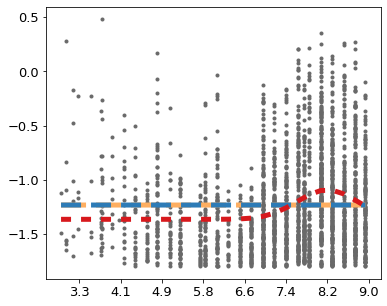

In [10]:
# I RUN THIS BLOCK TO GET THE X AXES IN THE CORRECT "DAYS POST DIFF" AND MONTHS CONVENTION 

days_in = compiled_data_days_kfm.ravel()
data_in = np.log10(compiled_data_taus_kfm_rsq_vec.ravel())



# remove nans
days_in = days_in[~np.isnan(data_in)]
data_in = data_in[~np.isnan(data_in)]

# normalize days
#days_np = np.array(days_in)
#days_in = (days_np - days_np.min()) / (days_np - days_np.min()).max()

# Create a mask based on the condition (time >= 0.2)

mask = [t >= 80 for t in days_in]

# Use the mask to filter both time and data
days_in = np.asarray([t for i, t in enumerate(days_in) if mask[i]])
data_in = np.asarray([d for i, d in enumerate(data_in) if mask[i]])


# guesses
guess_h1 = [
    np.max(data_in), # amplitude
    np.min(data_in), # offset
    np.max(days_in)/10, # gain
    np.max(days_in) # midpoint
]
guess_h2 = [
    np.max(data_in), # amplitude
    np.max(days_in), # mean
    np.max(days_in)/10, # standard deviation
    np.min(data_in) # offset
]
fit_method = 'trf' # 'lm', 'trf', 'dogbox'

# run fit
fig2_timescales(days_in,data_in,
                fit_method=fit_method,sig_func_type=sf,
                guess_h1=guess_h1,guess_h2=guess_h2, top_axis=True)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1]


ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (8).

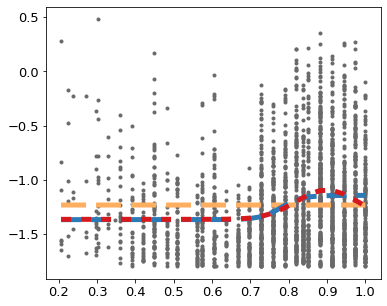

In [11]:
days_in = compiled_data_days_kfm.ravel()
data_in = np.log10(compiled_data_taus_kfm_rsq_vec.ravel())



# remove nans
days_in = days_in[~np.isnan(data_in)]
data_in = data_in[~np.isnan(data_in)]

# normalize days
days_np = np.array(days_in)
days_in = (days_np - days_np.min()) / (days_np - days_np.min()).max()

# Create a mask based on the condition (time >= 0.2)

mask = [t >= 0.2 for t in days_in]

# Use the mask to filter both time and data
days_in = np.asarray([t for i, t in enumerate(days_in) if mask[i]])
data_in = np.asarray([d for i, d in enumerate(data_in) if mask[i]])


# guesses
guess_h1 = [
    np.max(data_in), # amplitude
    np.min(data_in), # offset
    np.max(days_in)/10, # gain
    np.max(days_in) # midpoint
]
guess_h2 = [
    np.max(data_in), # amplitude
    np.max(days_in), # mean
    np.max(days_in)/10, # standard deviation
    np.min(data_in) # offset
]
fit_method = 'trf' # 'lm', 'trf', 'dogbox'

# run fit
fig2_timescales(days_in,data_in,
                fit_method=fit_method,sig_func_type=sf,
                guess_h1=guess_h1,guess_h2=guess_h2)

In [ ]:
np.sort(days_in)[0]


In [ ]:
days_in = compiled_data_days_kfm.ravel()
data_in = np.log10(compiled_data_taus_kfm_rsq_vec.ravel())



# remove nans
days_in = days_in[~np.isnan(data_in)]
data_in = data_in[~np.isnan(data_in)]

# normalize days
days_np = np.array(days_in)
days_in = (days_np - days_np.min()) / (days_np - days_np.min()).max()

# Create a mask based on the condition (time >= 0.2)
mask = [t >= 0.2 for t in days_in]

# Use the mask to filter both time and data
days_in = np.asarray([t for i, t in enumerate(days_in) if mask[i]])
data_in = np.asarray([d for i, d in enumerate(data_in) if mask[i]])


# guesses
guess_h1 = [
    np.max(data_in), # amplitude
    np.min(data_in), # offset
    np.max(days_in)/10, # gain
    np.max(days_in) # midpoint
]
guess_h2 = [
    np.max(data_in), # amplitude
    np.max(days_in), # mean
    np.max(days_in)/10, # standard deviation
    np.min(data_in) # offset
]
fit_method = 'trf' # 'lm', 'trf', 'dogbox'

# run fit
fig2_timescales(days_in,data_in,
                fit_method=fit_method,sig_func_type=sf,
                guess_h1=guess_h1,guess_h2=guess_h2)

In [ ]:
#linear version

days_in = compiled_data_days_kfm.ravel()
data_in = compiled_data_taus_kfm_rsq_vec.ravel()

# remove nans
days_in = days_in[~np.isnan(data_in)]
data_in = data_in[~np.isnan(data_in)]

# normalize days
days_np = np.array(days_in)
days_in = (days_np - days_np.min()) / (days_np - days_np.min()).max()

# Create a mask based on the condition (time >= 0.2)
mask = [t >= 0.2 for t in days_in]

# Use the mask to filter both time and data
days_in = np.asarray([t for i, t in enumerate(days_in) if mask[i]])
data_in = np.asarray([d for i, d in enumerate(data_in) if mask[i]])

# guesses
guess_h1 = [
    np.max(data_in), # amplitude
    np.min(data_in), # offset
    np.max(days_in)/10, # gain
    np.max(days_in) # midpoint
]
guess_h2 = [
    np.max(data_in), # amplitude
    0.9, # mean
    np.max(days_in)/10, # standard deviation
    np.min(data_in) # offset
]
fit_method = 'trf' # 'lm', 'trf', 'dogbox'

# run fit
fig2_timescales(days_in,data_in,
                fit_method=fit_method,sig_func_type=sf,
                guess_h1=guess_h1,guess_h2=None)